In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
# import pymfit
from astropy.io import fits
from astropy.wcs import WCS
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
import corner
import numpy as np
import os

In [2]:
def download_image_save_cutout(originalfile, position, size, cutoutfile):
    """Returns a cutout of agn from original exp.fits"""
    # Load the image and the WCS
    hdu = fits.open(originalfile)[0]
    wcs = WCS(hdu.header)
    # Make the cutout, including the WCS
    cutout = Cutout2D(hdu.data, position=position, size=size, wcs=wcs)
    # Put the cutout image in the FITS HDU
    hdu.data = cutout.data
    # Update the FITS header with the cutout WCS
    hdu.header.update(cutout.wcs.to_header())
    # Write the cutout to a new FITS file
    hdu.writeto(cutoutfile, overwrite=True)

In [14]:
catalog = pd.read_csv('../cutouts/catalog.txt', names=['name', 'ra', 'dec'], delimiter='\s+')

#ra  = catalog['ra'][catalog['name']== 'J1215+1344'].to_numpy()[0]
#dec  = catalog['dec'][catalog['name']== 'J1215+1344'].to_numpy()[0]

coords = [SkyCoord(ra=catalog['ra'].loc[i]*u.deg, dec=catalog['dec'].loc[i]*u.deg) for i in range(len(catalog))]
catalog['coords'] = coords
catalog.set_index("name",inplace=True)


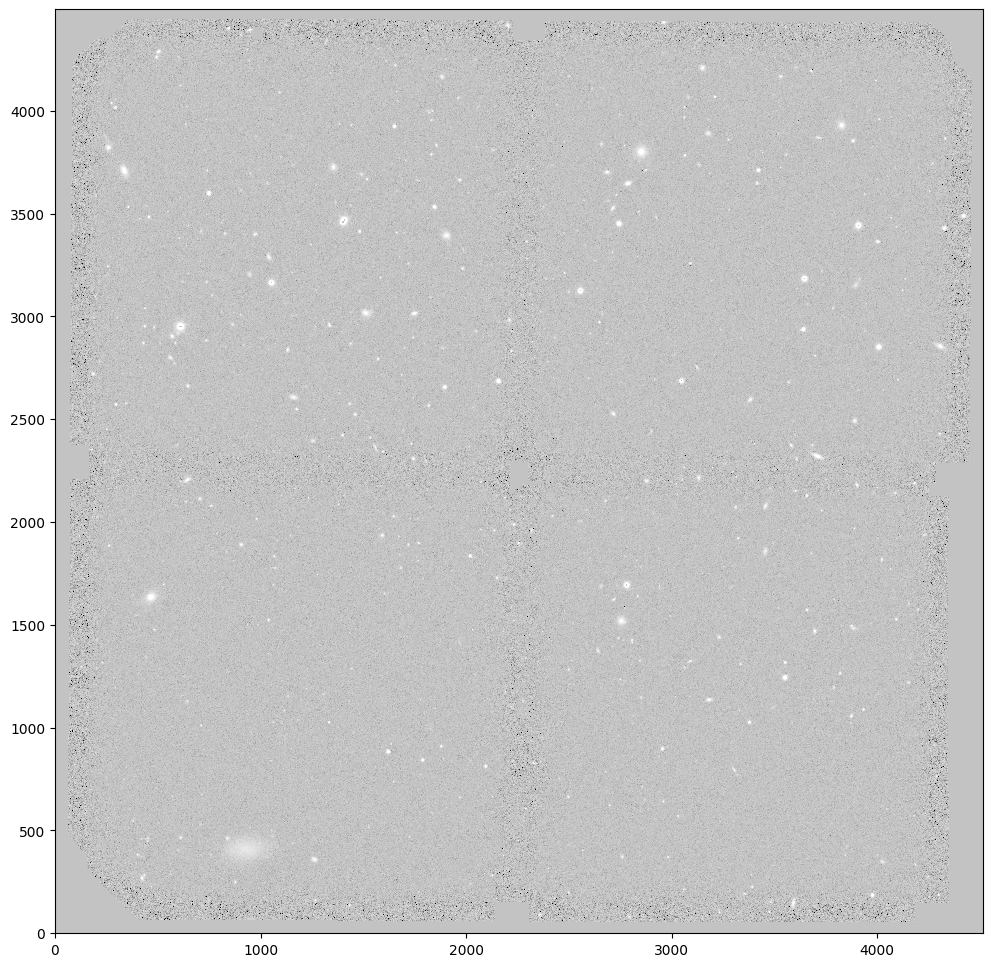

In [23]:
from astropy.visualization import simple_norm
data = fits.getdata("../../agn-data/2020-02-21_J_J1215+1344_c1-4_58900_32019.mos.fits")
norm = simple_norm(data, 'log', percent=99.9)
plt.figure(figsize=(12,12))
plt.imshow(data, cmap='Greys_r', origin='lower', norm=norm,
               interpolation='nearest')

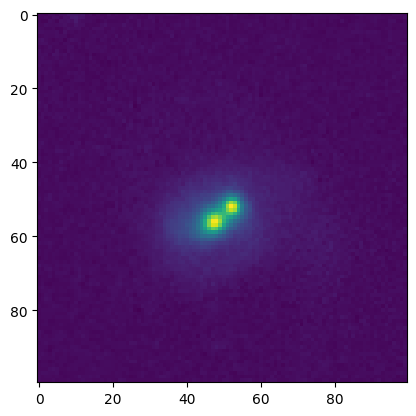

In [18]:
originalfile = "../../agn-data/2020-02-21_J_J1215+1344_c1-4_58900_32019.mos.fits"
position = catalog.loc['J1215+1344'].coords
size = (100,100)
hdu = fits.open(originalfile)[0]
wcs = WCS(hdu.header)
# Make the cutout, including the WCS
cutout = Cutout2D(hdu.data, position=position, size=size, wcs=wcs)
# Put the cutout image in the FITS HDU
plt.imshow(cutout.data)



J1308+0759.fits                                                                  [astropy.io.fits.card]
J1044+0637.fits                                                                  [astropy.io.fits.card]
J1245+0535.fits                                                                  [astropy.io.fits.card]
J0328-0710.fits                                                                  [astropy.io.fits.card]
J0323+0018.fits                                                                  [astropy.io.fits.card]
J0820+1801.fits                                                                  [astropy.io.fits.card]
J1504+0151.fits                                                                  [astropy.io.fits.card]
J1222-0007.fits                                                                  [astropy.io.fits.card]
J0859+1001.fits                                                                  [astropy.io.fits.card]
J1340-0308.fits                                                 

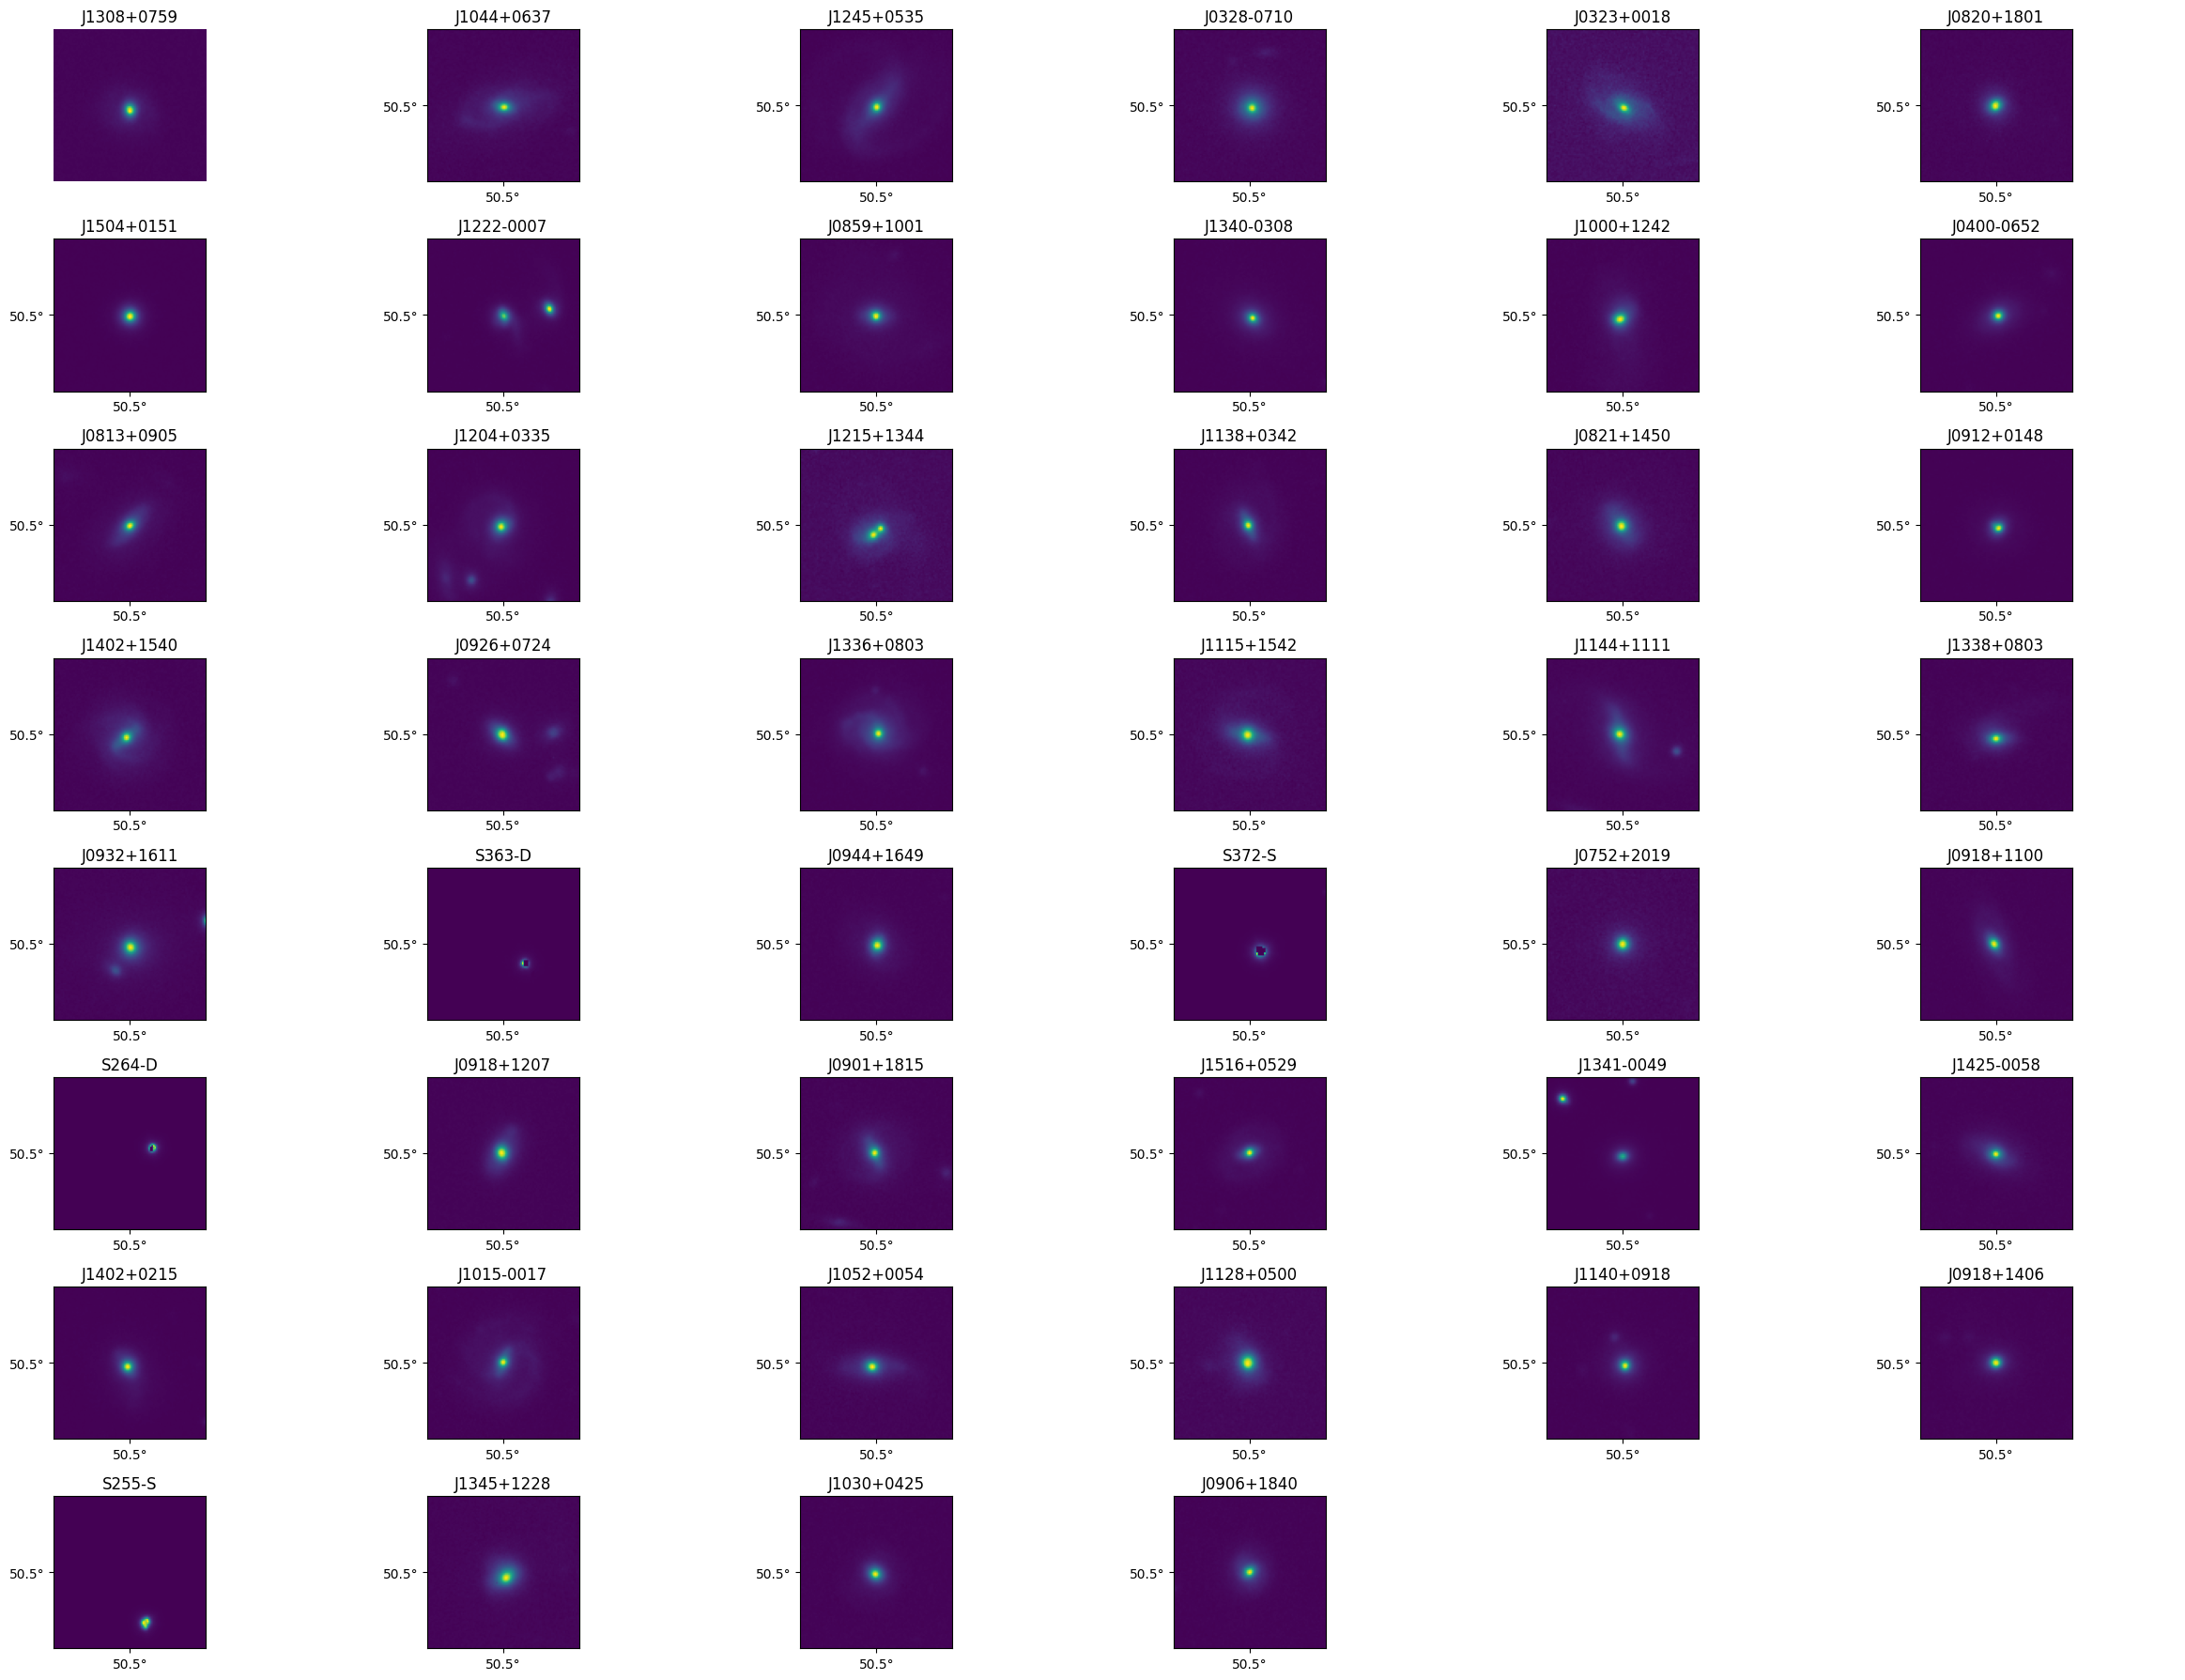

In [7]:
def plot_all(fileNames):
    n = len(fileNames)
    ncols=6
    nrows=int(np.ceil(n/6))
    fig,ax = plt.subplots(nrows,ncols,figsize=(nrows*3,ncols*3))
    ax = ax.ravel()
    for i in range(n):
        dpath = "../cutouts/data/"+fileNames[i]
        ax[i].imshow(fits.getdata(dpath))
        ax[i].set_title(fileNames[i].split(".")[0])
        w = WCS(fileNames[i])
        ra,dec = w.all_pix2world(np.arange(100),np.arange(100),0)
        xlabel = np.round(np.linspace(ra[0],ra[-1],3),2)
        ylabel = np.round(np.linspace(dec[0],dec[-1],3),2)
        ax[i].set_xticks([np.linspace(0, 99, 3)[1]], [f"{xlabel[1]}°"])
        ax[i].set_yticks([np.linspace(0, 99, 3)[1]], [f"{ylabel[1]}°"])
    [ax[-i].axis("off") for i in range(1,len(ax)-n+1)]
    fig.tight_layout()
    return fig

fileNames = os.listdir("../cutouts/data")
fig = plot_all(fileNames)

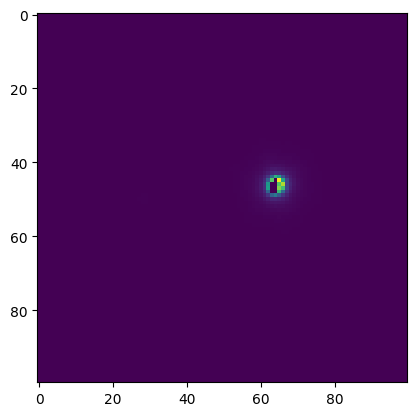

In [76]:

w = WCS('test_cutout.fits')
ra,dec = w.all_pix2world(np.arange(100),np.arange(100),0)
plt.imshow(fits.getdata("test_cutout.fits"))
#xlabel = np.round(np.linspace(ra[0],ra[-1],6),3)
#ylabel = np.round(np.linspace(dec[0],dec[-1],6),3)
#plt.xticks(np.linspace(0, 99, 6), [f"{x}°" for x in xlabel])
#plt.yticks(np.linspace(0, 99, 6), [f"{y}°" for y in ylabel]);

In [7]:
og_img = '../fourstar_reductions/2020-02-21_J_J1215+1344_c1-4_58900_32019.mos.fits'

In [8]:
download_image_save_cutout(og_img, coords, (100, 100), '/Users/kpardo/Desktop/test.fits')

In [9]:
img = '/Users/kpardo/Desktop/test.fits'

In [10]:
f = fits.open(img)
w = WCS(f[0].header)

In [8]:
X0, Y0 = w.world_to_pixel(coords)

In [9]:
X0

array(49.64756197)

In [10]:
model_ps_0 = pymfit.Model(
    funcs = ['Sersic'],    # Function names
    params = [{'X0':[X0, 40,60], 'Y0':[Y0, 40,60],
               'PA':[245, 0,360.], 'ell':[0.3, 0,1],
               'n':[1.0, 0,4], 'I_e':[23, 0, 30], 'r_e':[9, 0.1,20]
              }],       # Initial params that are different from default
    centers = [[X0, Y0]],  # guess for centers
    dcent = 30           # delta center (i.e., (X0, Y0) +/- dcent)
)
model_ps_1 = pymfit.Model(
    funcs = ['Sersic', 'Gaussian'],    # Function names
    params = [None, None],       # Initial params that are different from default
    centers = [[X0, Y0], [X0, Y0]],  # guess for centers
    dcent = 30           # delta center (i.e., (X0, Y0) +/- dcent)
)
model_ps_2 = pymfit.Model(
    funcs = ['Sersic', 'Gaussian', 'Gaussian'],    # Function names
    params = [{'PA':245.8450, 'X0':49.4427,'Y0':56.0463,
               'ell':0.2760, 'n':1.1231, 'I_e':23.3279,'r_e':10.0254},
              None, None],       # Initial params that are different from default
    centers = [[X0, Y0], [X0, Y0], [X0,Y0]],  # guess for centers
    dcent = 50           # delta center (i.e., (X0, Y0) +/- dcent)
)
fitter = pymfit.PymFitter(model_ps_0)

In [15]:
fitter.run(img, var_fn=img, will_viz=False, mcmc=True) 

KeyboardInterrupt: 

In [47]:
chains

array([[4.94888342e+01, 5.60526100e+01, 2.45912050e+02, ...,
        1.34787604e-03, 4.23604964e+00, 9.34858905e-01],
       [4.94888342e+01, 5.60526100e+01, 2.45912050e+02, ...,
        1.34787604e-03, 4.23604964e+00, 9.34858905e-01],
       [4.94888342e+01, 5.60526100e+01, 2.45912050e+02, ...,
        1.34787604e-03, 3.96899365e+00, 9.34858905e-01],
       ...,
       [4.94497182e+01, 5.61063342e+01, 2.45077277e+02, ...,
        2.99617900e-02, 3.12424048e+00, 9.76903311e-01],
       [4.94497182e+01, 5.61063342e+01, 2.45077277e+02, ...,
        2.99617900e-02, 3.12424048e+00, 9.76903311e-01],
       [4.94497182e+01, 5.61063342e+01, 2.45077277e+02, ...,
        2.99617900e-02, 3.12424048e+00, 9.76903311e-01]])

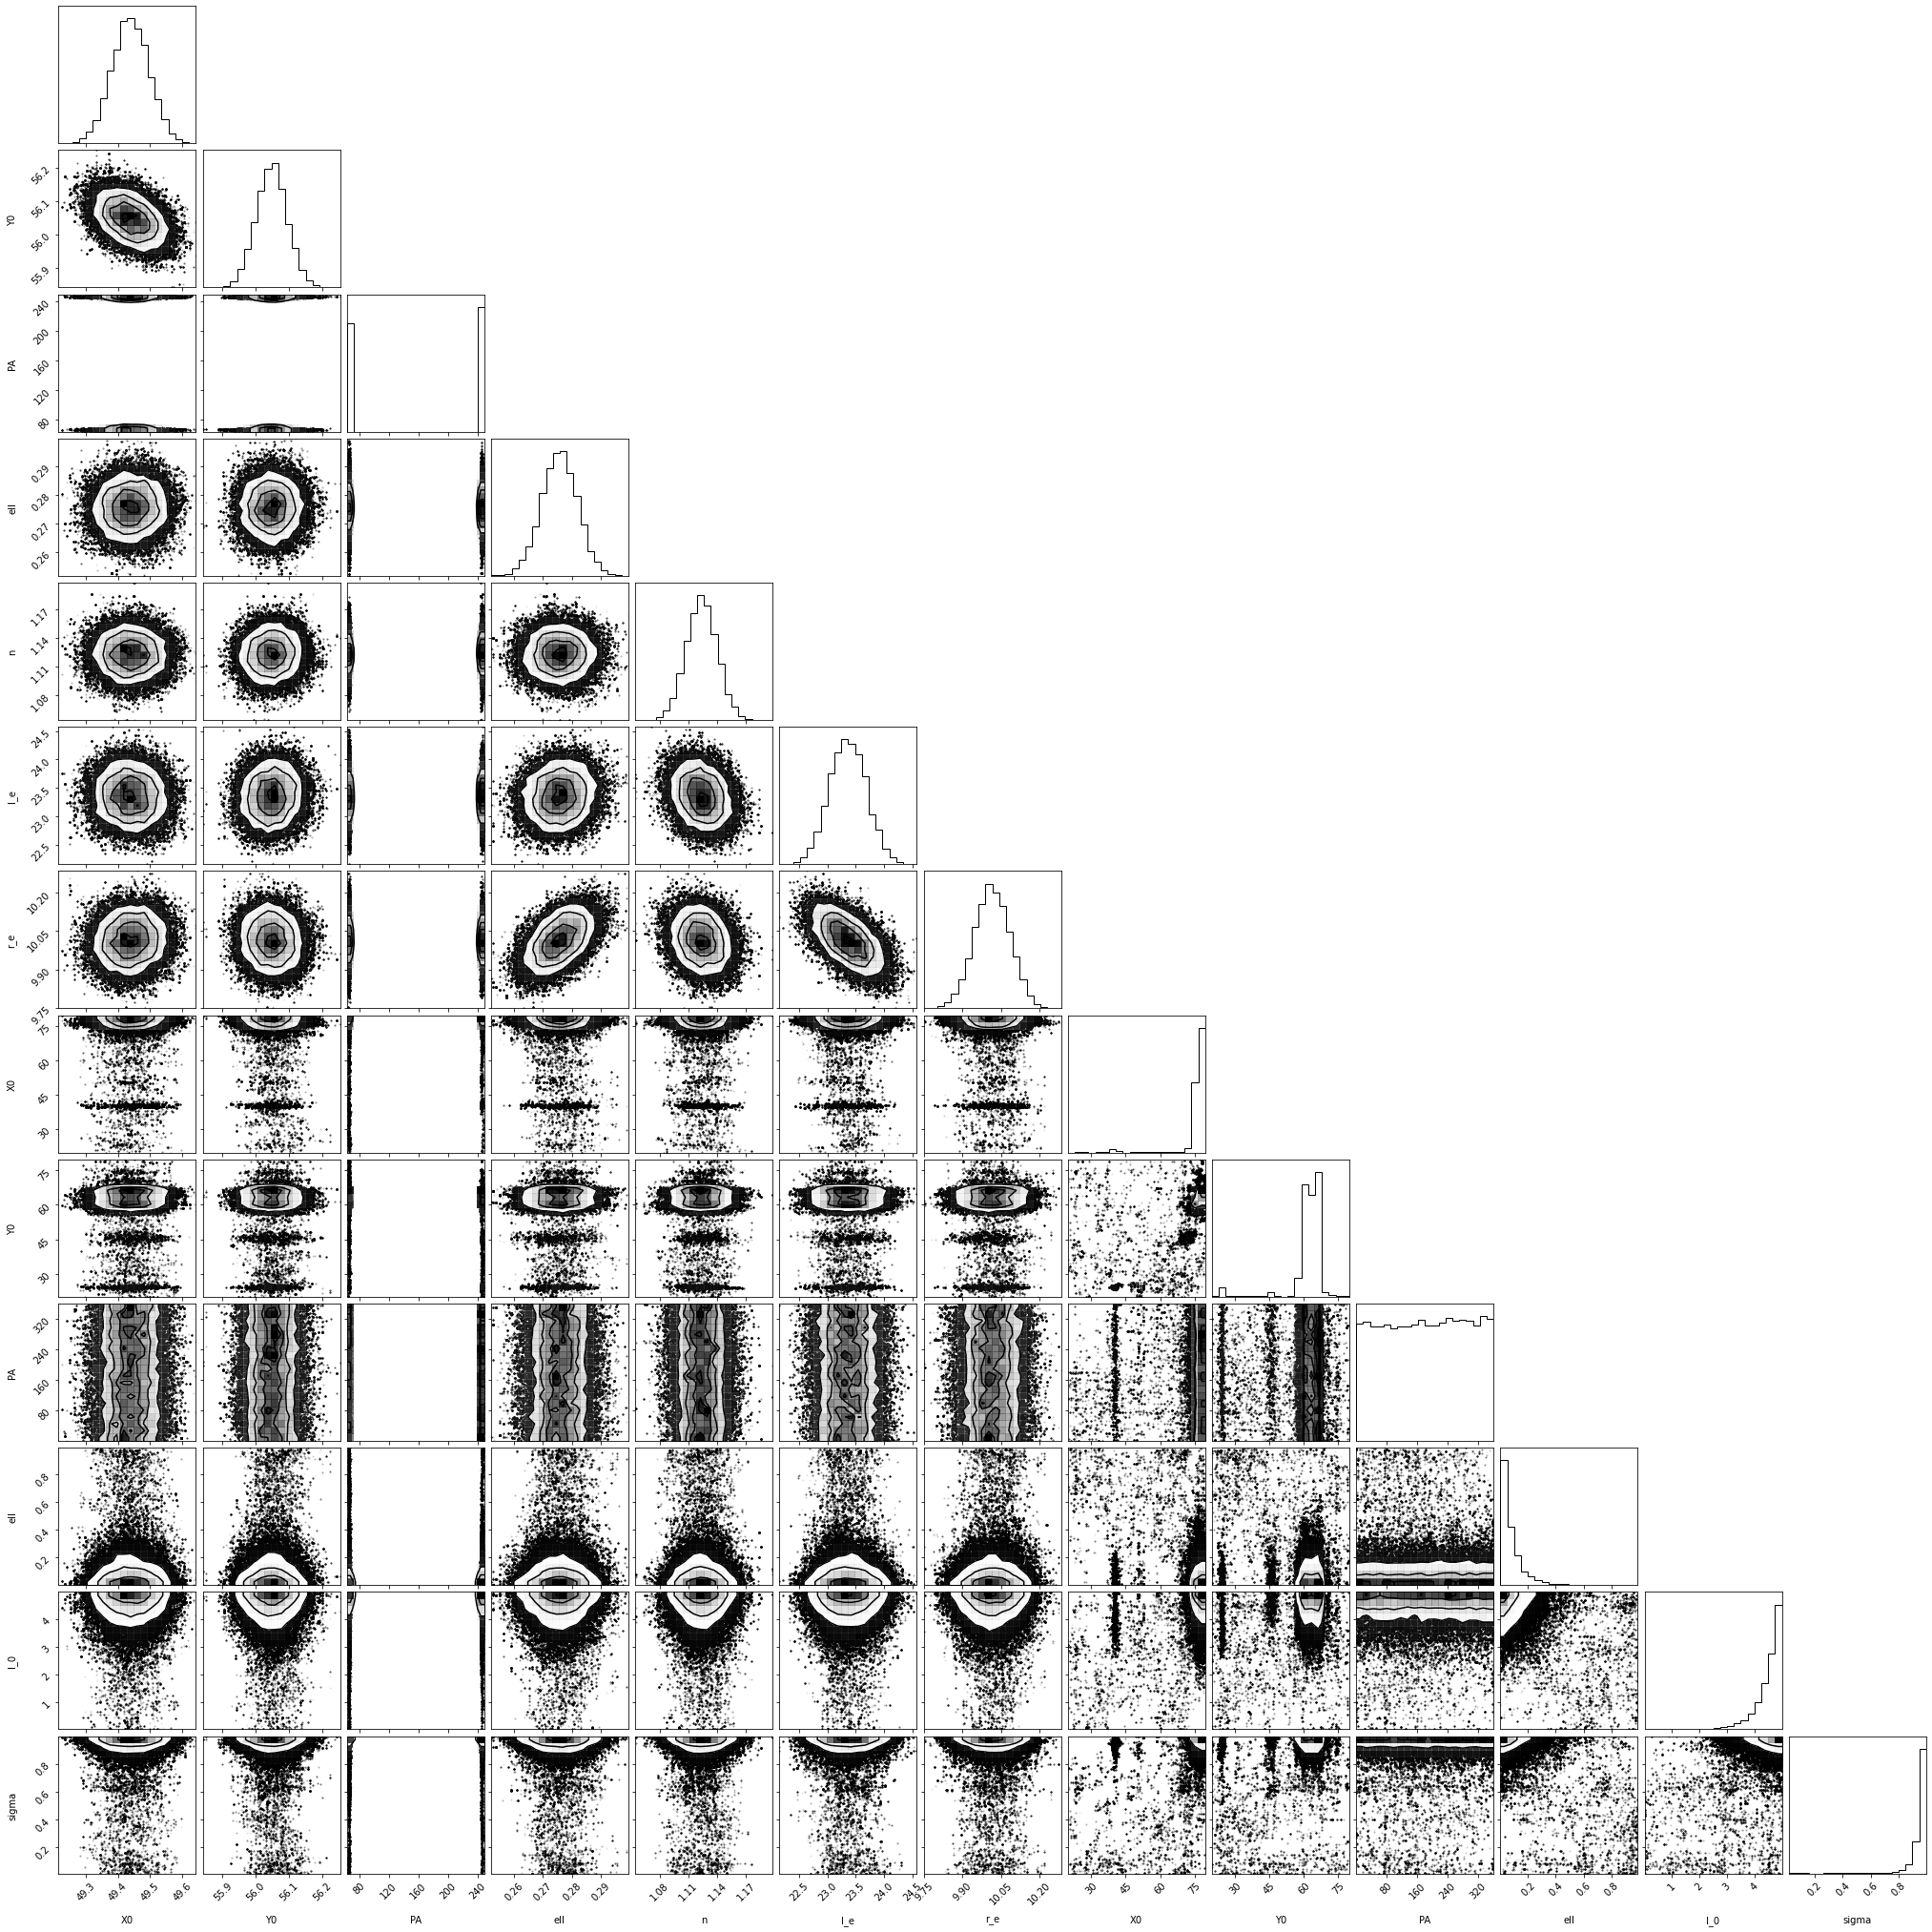

In [50]:
corner.corner(chains, labels=col_names);

In [35]:
import glob
def MergeChains( fname_root, maxChains=None, getAllColumns=False, start=10000, last=None,
				secondHalf=False  ):
	"""
	Reads and concatenates all MCMC output chains with filenames = fname_root.*.txt,
	using data from t=start onwards. By default, all generations from each chain
	are extracted; this can be modified with the start, last, or secondHalf keywords.
	Parameters
	----------
	fname_root : str
		root name of output chain files (e.g., "mcmc_out")
	maxChains : int or None, optional
		maximum number of chain files to read [default = None = read all files]
	getAllColumns : bool, optional
		if False [default], only model parameter-value columns are retrieved;
		if True, all output columns (including MCMC diagnostics) are retrieved
	start : int, optional
		extract samples from each chain beginning with time = start
		ignored if "secondHalf" is True or if "last" is not None
	last : int or None, optional
		extract last N samples from each chain
		ignored if "secondHalf" is True
	secondHalf : bool, optional
		if True, only the second half of each chain is extracted
		if False [default],
	Returns
	-------
	(column_names, data_array) : tuple of (list, np.ndarray)
		column_names = list of column names (strings)
		data_array = numpy array of parameter values
			with shape = (n_samples, n_parameters)
	"""

	# construct list of filenames
	if maxChains is None:
		globPattern = "{0}.*.txt".format(fname_root)
		filenames = glob.glob(globPattern)
	else:
		filenames = ["{0}.{1}.txt".format(fname_root, n) for n in range(maxChains)]
	nFiles = len(filenames)

	# get the first chain so we can tell how long the chains are
	(colNames, dd) = GetSingleChain(filenames[0], getAllColumns=getAllColumns)
	nGenerations = dd.shape[0]

	# figure out what part of full chain to extract
	if secondHalf is True:
		startTime = int(np.floor(nGenerations / 2))
	elif last is not None:
		startTime = -last
	else:
		startTime = start

	# get first chain and column names; figure out if we get all columns or just
	# model parameters
	if (startTime >= nGenerations):
		txt = "WARNING: # generations in MCMC chain file {0} ({1:d}) is <= ".format(filenames[0],
				nGenerations)
		txt += "requested start time ({0:d})!\n".format(startTime)
		print(txt)
		return None
	dd_final = dd[startTime:,:]
	if getAllColumns is False:
		nParamColumns = len(colNames)
		whichCols = list(range(nParamColumns))
	else:
		whichCols = None

	# get and append rest of chains if more than 1 chain-file was requested
	if nFiles > 1:
		for i in range(1, nFiles):
			dd_next = np.loadtxt(filenames[i], usecols=whichCols)
			dd_final = np.concatenate((dd_final, dd_next[startTime:,:]))

	return (colNames, dd_final)

def GetSingleChain( filename, getAllColumns=False ):
	"""Reads a single MCMC chain output file and returns a tuple of column names
	and a numpy array with the data.
	Parameters
	----------
	filename : str
		name of file with MCMC output chain
	getAllColumns: bool, optional
		if False [default], only model parameter-value columns are retrieved;
		if True, all output columns (including MCMC diagnostics) are retrieved
	Returns
	-------
	(column_names, data_array) : tuple of (list, np.ndarray)
		column_names = list of column names (strings)
		data_array = numpy array of parameter values
			with shape = (n_iterations, n_parameters)
	"""

	# get first 100 lines
	# FIXME: file *could* be shorter than 100 lines; really complicated
	# model could have > 100 lines of header...
	with open(filename) as theFile:
		firstLines = [next(theFile) for x in range(100)]

	# find header line with column names and extract column names
	for i in range(len(firstLines)):
		if firstLines[i].find("# Column Headers") >= 0:
			columnNamesIndex = i + 1
			break
	columnNames = firstLines[columnNamesIndex][1:].split()
	for i in range(len(columnNames)):
		if columnNames[i] == "likelihood":
			nParamColumns = i
			break

	# get data for all columns, or just the model parameters?
	whichCols = None
	if not getAllColumns:
		whichCols = list(range(nParamColumns))
		outputColumnNames = columnNames[:nParamColumns]
	else:
		whichCols = None
		outputColumnNames = columnNames

	# get the data
	d = np.loadtxt(filename, usecols=whichCols)

	return (outputColumnNames, d)

In [37]:
col_names, chains = MergeChains('mcmc_out', secondHalf=True)
col_names = [cn[:-2] for cn in col_names]

['X0', 'Y0', 'PA', 'ell', 'n', 'I_e', 'r_e', 'X0', 'Y0', 'PA', 'ell', 'I_0', 'sigma']


In [12]:
fitter.print_results()


Component  1
---------------------
Function   Sersic
X0         49.3335
Y0         56.0608
PA         0.0000
ell        0.0000
n          1.2938
I_e        18.0066
r_e        8.8649


In [13]:
fitter.results['reduced_chisq']

1.24423

In [17]:
fitter = pymfit.PymFitter(model_ps_1)
fitter.run(img, var_fn=img, will_viz=False, mcmc=True) 
# fitter.viz_results();
# fitter.print_results()
# fitter.results['reduced_chisq']

FileNotFoundError: [Errno 2] No such file or directory: './best-fit.txt'

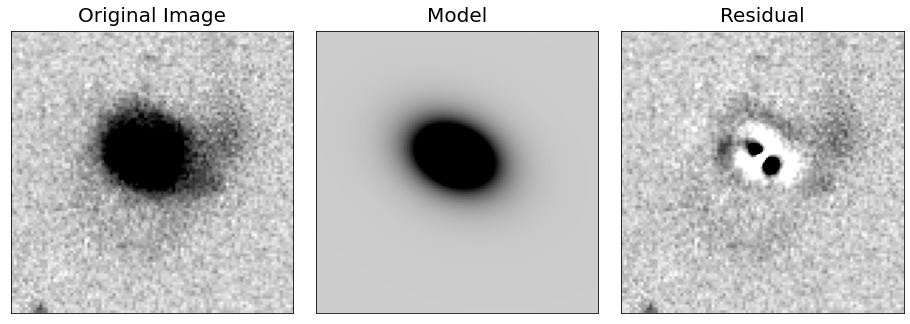


Component  1
---------------------
Function   Sersic
X0         49.4527
Y0         56.0333
PA         245.9030
ell        0.2759
n          1.1207
I_e        23.2577
r_e        10.0387

Component  2
---------------------
Function   Gaussian
X0         56.0333
Y0         47.8925
PA         360.0000
ell        0.0000
I_0        5.0000
sigma      1.0000

Component  3
---------------------
Function   Gaussian
X0         47.8925
Y0         58.6118
PA         0.0000
ell        0.9116
I_0        0.0100
sigma      0.0497


1.012868

In [16]:
fitter = pymfit.PymFitter(model_ps_2)
fitter.run(img, var_fn=img, will_viz=True, mcmc=False) 
fitter.viz_results();
fitter.print_results()
fitter.results['reduced_chisq']